In [1]:
import sys
# sys.path.insert(0, '/home/cscadmin/CyberResearch/CAT-Transformer/model')
sys.path.insert(0, r'C:\Users\smbm2\projects\CAT-Transformer\model')
# sys.path.insert(0, '/home/warin/projects/CAT-Transformer/model')
from updatedModel import CATTransformer, Combined_Dataset, train, test, count_parameters
from updatedModel import MyFTTransformer
from tab_transformer_pytorch import FTTransformer
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
device_in_use = 'cpu'

In [3]:
#HELENA
df_train = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\helena\train.csv')
df_test = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\helena\test.csv')
df_val = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\helena\validation.csv') #READ FROM RIGHT SPOT

# df_train = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/helena/train.csv')
# df_test = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/helena/test.csv')
# df_val = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/helena/validation.csv')

# df_train = pd.read_csv('/home/warin/projects/CAT-Transformer/datasets/helena/train.csv')
# df_test = pd.read_csv('/home/warin/projects/CAT-Transformer/datasets/helena/test.csv')
# df_val = pd.read_csv('/home/warin/projects/CAT-Transformer/datasets/helena/validation.csv')


# df_train.columns
cont_columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27']
target = ['class']

#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cont_columns + target
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put one of them in the list"

target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]
print("target classes",target_classes)
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

#Wrapping in Dataset
train_dataset = Combined_Dataset(df_train, cat_columns=[], num_columns=cont_columns, task1_column='class')
val_dataset = Combined_Dataset(df_val, cat_columns=[], num_columns=cont_columns, task1_column='class')
test_dataset = Combined_Dataset(df_test, cat_columns=[], num_columns=cont_columns, task1_column='class')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

target classes [100]


In [3]:
model = CATTransformer(n_cont=len(cont_columns),
                       cat_feat=[], #pass cat_feat an emtpy list if dataset contains no cat features
                       targets_classes=target_classes,
                       embed_size=160
                       ).to(device_in_use)
count_parameters(model)

1181764

In [4]:
ftmodel = MyFTTransformer(n_cont=len(cont_columns),
                       cat_feat=[], #pass cat_feat an emtpy list if dataset contains no cat features
                       targets_classes=target_classes,
                       embed_size=160).to(device_in_use)
count_parameters(ftmodel)

1181764

In [6]:
lucidftmodel = FTTransformer(categories=(),
                             num_continuous=len(cont_columns),
                             dim=160,
                             depth=1,
                             heads=5)
count_parameters(lucidftmodel)

369761

In [7]:

# Training and Testing Loops
def train_ft(dataloader, model, loss_function, optimizer, device_in_use):
    model.train()

    total_loss = 0
    total_correct_1 = 0
    total_samples_1 = 0
    all_targets_1 = []
    all_predictions_1 = []

    for (numerical, labels_task1) in dataloader:
        numerical, labels_task1 = numerical.to(device_in_use), labels_task1.to(device_in_use)
        #FT requires categorical, so must pass empty tensor since there are no cat features in this dataset
        categorical = torch.tensor([]).to(device_in_use)
        #running them through model and modifying the shape slightly for the loss function
        task_predictions = model(categorical, numerical)
        task_predictions = task_predictions.squeeze(1)
        
        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()
        
        #computing accuracy for first target
        y_pred_softmax_1 = torch.softmax(task_predictions, dim=1)
        _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
        total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
        total_samples_1 += labels_task1.size(0)
        all_targets_1.extend(labels_task1.cpu().numpy())
        all_predictions_1.extend(y_pred_labels_1.cpu().numpy())


        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss/len(dataloader)
    accuracy_1 = total_correct_1 / total_samples_1

    return avg_loss, accuracy_1

def test_ft(dataloader, model, loss_function, device_in_use):
    model.eval()
    total_loss = 0
    
    total_loss = 0
    total_correct_1 = 0
    total_samples_1 = 0
    all_targets_1 = []
    all_predictions_1 = []

    with torch.no_grad():
        for (numerical, labels_task1) in dataloader:
            numerical, labels_task1 = numerical.to(device_in_use), labels_task1.to(device_in_use)

            categorical = torch.tensor([]).to(device_in_use)
            task_predictions = model(categorical, numerical)
            task_predictions = task_predictions.squeeze(1)
            loss = loss_function(task_predictions, labels_task1)
            total_loss += loss.item()
            
            #computing accuracy for first target
            y_pred_softmax_1 = torch.softmax(task_predictions, dim=1)
            _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
            total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
            total_samples_1 += labels_task1.size(0)
            all_targets_1.extend(labels_task1.cpu().numpy())
            all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

    avg = total_loss/len(dataloader)
    accuracy_1 = total_correct_1 / total_samples_1
    f1_1 = f1_score(all_targets_1, all_predictions_1, average='weighted')

    return avg, accuracy_1, all_predictions_1, all_targets_1, f1_1


In [5]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=ftmodel.parameters(), lr=0.0001)

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 

epochs = 100

for t in range(epochs):
    train_loss, train_acc = train(regression_on=False, 
                                   dataloader=train_dataloader, 
                                   model=ftmodel, 
                                   loss_function=loss_function, 
                                   optimizer=optimizer, 
                                   device_in_use=device_in_use)
    test_loss, test_acc = test(regression_on=False,
                               dataloader=test_dataloader,
                               model=ftmodel,
                               loss_function=loss_function,
                               device_in_use=device_in_use)
    train_losses.append(train_loss)
    train_accuracies_1.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies_1.append(test_acc)

    epoch_str = f"Epoch [{t+1:2}/{epochs}]"
    train_metrics = f"Train: Loss {(train_loss)}, Accuracy {(train_acc)}"
    test_metrics = f"Test: Loss {(test_loss)}, Accuracy {(test_acc)}"
    print(f"{epoch_str:15} | {train_metrics:65} | {test_metrics:65}")

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")

Epoch [ 1/100]  | Train: Loss 4.05853426922633, Accuracy 0.11061200341827902        | Test: Loss 3.5613064765930176, Accuracy 0.19478527607361965      
Epoch [ 2/100]  | Train: Loss 3.4327627546960415, Accuracy 0.22529964721607468      | Test: Loss 3.2123569280673294, Accuracy 0.269120654396728        
Epoch [ 3/100]  | Train: Loss 3.20868951781502, Accuracy 0.2687950566426365         | Test: Loss 3.061460800659962, Accuracy 0.2952965235173824        
Epoch [ 4/100]  | Train: Loss 3.081029472404352, Accuracy 0.28807765628766135       | Test: Loss 2.9744006976103172, Accuracy 0.310838445807771        
Epoch [ 5/100]  | Train: Loss 3.002226427280703, Accuracy 0.29883647040778316       | Test: Loss 2.912030599056146, Accuracy 0.318200408997955         
Epoch [ 6/100]  | Train: Loss 2.9372530849286296, Accuracy 0.30880645090606307      | Test: Loss 2.87106468127324, Accuracy 0.32280163599182005        
Epoch [ 7/100]  | Train: Loss 2.8923932480412486, Accuracy 0.31581830532243577      | Te

KeyboardInterrupt: 

In [7]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

train_losses_cat = []
train_accuracies_1_cat = [] 
test_losses_cat = []
test_accuracies_1_cat = [] 
test_f1_scores_cat = [] 

epochs = 100

for t in range(epochs):
    train_loss, train_acc = train(regression_on=False, 
                                   dataloader=train_dataloader, 
                                   model=model, 
                                   loss_function=loss_function, 
                                   optimizer=optimizer, 
                                   device_in_use=device_in_use)
    test_loss, test_acc = test(regression_on=False,
                               dataloader=test_dataloader,
                               model=model,
                               loss_function=loss_function,
                               device_in_use=device_in_use)
    train_losses_cat.append(train_loss)
    train_accuracies_1_cat.append(train_acc)
    test_losses_cat.append(test_loss)
    test_accuracies_1_cat.append(test_acc)

    epoch_str = f"Epoch [{t+1:2}/{epochs}]"
    train_metrics = f"Train: Loss {(train_loss)}, Accuracy {(train_acc)}"
    test_metrics = f"Test: Loss {(test_loss)}, Accuracy {(test_acc)}"
    print(f"{epoch_str:15} | {train_metrics:65} | {test_metrics:65}")

best_index = test_accuracies_1.index(max(test_accuracies_1_cat))
print(f"Best accuracy {test_accuracies_1_cat[best_index]}")

Epoch [ 1/100]  | Train: Loss 2.0485690186143586, Accuracy 0.4680412822928764       | Test: Loss 2.6414942985925918, Accuracy 0.38987730061349696      
Epoch [ 2/100]  | Train: Loss 2.034453952112677, Accuracy 0.4683042268334904        | Test: Loss 2.636844897881532, Accuracy 0.39100204498977503       
Epoch [ 3/100]  | Train: Loss 2.0313681031072606, Accuracy 0.46944365317615094      | Test: Loss 2.6385332621060886, Accuracy 0.3861963190184049       
Epoch [ 4/100]  | Train: Loss 2.0252557653288603, Accuracy 0.4716348576812674       | Test: Loss 2.642316695971367, Accuracy 0.3878323108384458        
Epoch [ 5/100]  | Train: Loss 2.0130646415262916, Accuracy 0.47428621513245833      | Test: Loss 2.648555773955125, Accuracy 0.38732106339468303       
Epoch [ 6/100]  | Train: Loss 2.012407214947919, Accuracy 0.47527225715976074       | Test: Loss 2.6434654822716346, Accuracy 0.3903885480572597       
Epoch [ 7/100]  | Train: Loss 2.006019060172182, Accuracy 0.4747682801235839        | Te

ValueError: 0.39100204498977503 is not in list

In [9]:
best_index = test_accuracies_1_cat.index(max(test_accuracies_1_cat))
print(f"Best accuracy {test_accuracies_1_cat[best_index]}")

Best accuracy 0.39100204498977503


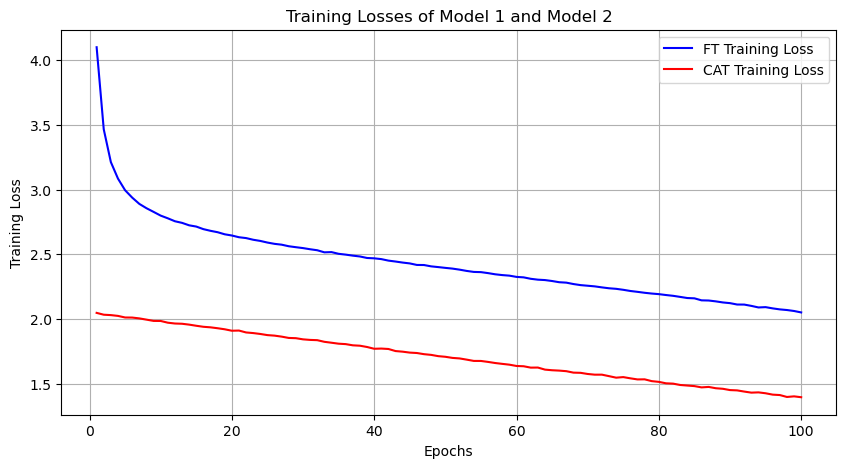

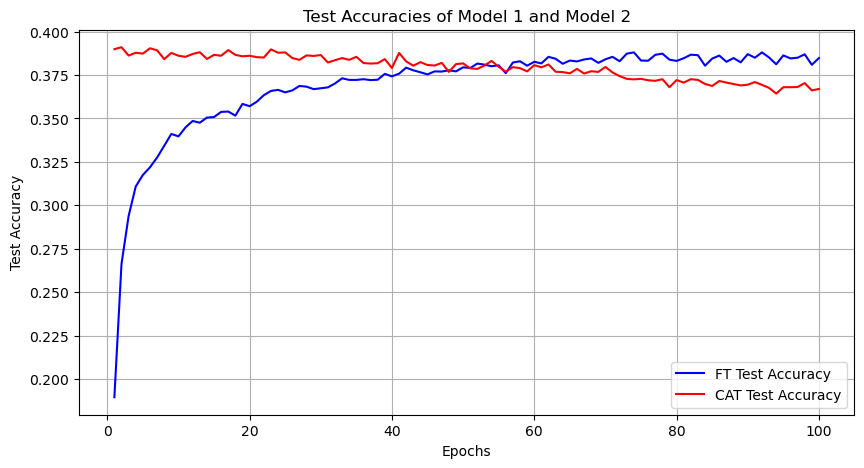

In [13]:
epochs = range(1, len(train_losses) + 1)

# Plotting training losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='FT Training Loss')
plt.plot(epochs, train_losses_cat, 'r', label='CAT Training Loss')
plt.title('Training Losses of Model 1 and Model 2')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting test accuracies
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_accuracies_1, 'b', label='FT Test Accuracy')
plt.plot(epochs, test_accuracies_1_cat, 'r', label='CAT Test Accuracy')
plt.title('Test Accuracies of Model 1 and Model 2')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()